In [1]:
from glob import glob
import pandas as pd
from tqdm import tqdm
import logging
logging.basicConfig(
    level=logging.INFO,
    format=u'%(asctime)s - %(levelname)s - %(message)s')

In [2]:
glob('./data/*.csv')

['./data/train.csv', './data/test.csv', './data/cheet.csv']

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_add   = pd.read_csv('./data/cheet.csv')
df_test  = pd.read_csv('./data/test.csv')

In [4]:
for file in [df_train,df_add,df_test]:
    print(file.shape)

(146811, 3)
(62918, 2)
(60427, 2)


In [8]:
df_train = df_train[['review','rating']]
df_test['rating'] = -1
df_test = df_test[['review','rating']]

In [9]:
df_train = pd.concat([df_train,df_add],axis=0)

In [10]:
df_train['rating'] = df_train['rating']  -1

# model train

In [11]:
# check length
print(f'train data tile length max: {df_train.review.str.len().max()}')
print(f'train data tile length max: {df_train.review.str.len().median()}')

print(f'test data tile length max: {df_test.review.str.len().max()}')
print(f'test data tile length max: {df_test.review.str.len().median()}')

train data tile length max: 1500
train data tile length max: 72.0
test data tile length max: 1117
test data tile length max: 78.0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc_context({'axes.edgecolor': 'orange', 'xtick.color': 'red',
                'ytick.color': 'green', 'figure.facecolor': 'white'})

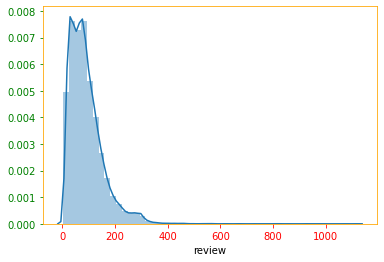

In [13]:
sns.distplot(df_test.review.str.len())

In [ ]:
# truncate data length large than test data length max
MAX_LENGTH = 120
BATCH_SIZE = 32

df_train.review = df_train.review.apply(lambda x : str(x)[:MAX_LENGTH])
df_test.review  = df_test.review.apply(lambda x : str(x)[:MAX_LENGTH])

In [16]:
# sample rate
SAMPLE_FRAC = 1
VAILD_RATIO = 0.9

data_1 = df_train.sample(frac=SAMPLE_FRAC)

train_data = data_1[:int(VAILD_RATIO*len(data_1))].reset_index(drop=1)
valid_data = data_1[int(VAILD_RATIO*len(data_1)):].reset_index(drop=1)

print(f'train data length: {len(train_data)}')
print(f'valid data length: {len(valid_data)}')
display(train_data.head())

train data length: 188756
valid data length: 20973


,review,rating
0,Akh tp products both confused mask is suitable...,2
1,Good product quality product quality good pri...,2
2,Very many things The unique mix very classy ye...,4
3,"Okay, hopefully durable! 🙏",1
4,Loved it kesetnyaa ...,4


In [ ]:
import torch
from transformers import *
NUM_LABELS = len(df_train.rating.unique())
#PRETRAINED_MODEL_NAME = 'bert-base-uncased'
PRETRAINED_MODEL_NAME = "roberta-base"

tokenizer = RobertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
import emoji
from torch.utils.data import Dataset

def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ''.join([str for str in text if not any(i in str for i in emoji_list)])
    return clean_text

class FakeNewsDataset(Dataset):
    def __init__(self, df, mode, tokenizer):
        self.mode = mode
        self.df = df
        self.len = len(self.df)
        self.tokenizer = tokenizer

    def __getitem__(self, idx):

        text, label = self.df.iloc[idx, :2].values
        label_tensor = torch.tensor(label)
        word_pieces = ["[CLS]"]

        text = give_emoji_free_text(str(text))
        text = text[:MAX_LENGTH-2]
        text = text.lower()
        tokens_a = tokenizer.tokenize(text)

        word_pieces += tokens_a + ["[SEP]"]
        len_a = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        segments_tensor = torch.tensor([0] * len_a, dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len

In [21]:
trainset = FakeNewsDataset(train_data,"train", tokenizer=tokenizer)
validset = FakeNewsDataset(valid_data,"valid", tokenizer=tokenizer)
testset  = FakeNewsDataset(df_test   ,"test" , tokenizer=tokenizer)

In [22]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


trainloader = DataLoader(trainset,
                         batch_size=BATCH_SIZE,
                         collate_fn=create_mini_batch)
validloader = DataLoader(validset,
                         batch_size=BATCH_SIZE,
                         collate_fn=create_mini_batch)
testloader = DataLoader(testset,
                        batch_size=BATCH_SIZE,
                        collate_fn=create_mini_batch)

In [23]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    prob = None
    correct = 0
    total = 0
    loss = 0
    count = 0
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to(device) for t in data if t is not None]
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors,
                            token_type_ids=segments_tensors,
                            attention_mask=masks_tensors)
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            _prob = torch.nn.functional.softmax(logits, dim=1)

            count += 1
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                loss += torch.nn.functional.cross_entropy(logits, labels)

            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))

            if prob is None:
                prob = _prob
            else:
                prob = torch.cat((prob, _prob))

    if compute_acc:
        acc = correct / total
        loss = loss / count
        return predictions, acc, loss
    return prob

In [24]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)  # lr=1r-6 (40)
EPOCHS = 100
for epoch in range(EPOCHS):
    for data in trainloader:
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]
        optimizer.zero_grad()
        outputs = model(input_ids=tokens_tensors,
                        token_type_ids=segments_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
    prob1, acc1, loss1 = get_predictions(model, trainloader, compute_acc=True)
    prob2, acc2, loss2 = get_predictions(model, validloader, compute_acc=True)

    logging.info(
        f"""[epoch {(epoch + 1):2d}] loss: {loss1:.3f}, acc: {acc1:.3f}, valid_loss: {loss2:.3f}, valid_acc: {acc2:.3f}"""
    )

2020-07-25 12:48:02,314 - INFO - [epoch  1] loss: 1.080, acc: 0.476, valid_loss: 1.091, valid_acc: 0.461
2020-07-25 13:04:49,131 - INFO - [epoch  2] loss: 1.048, acc: 0.485, valid_loss: 1.063, valid_acc: 0.478
2020-07-25 13:21:35,123 - INFO - [epoch  3] loss: 1.028, acc: 0.496, valid_loss: 1.048, valid_acc: 0.483
2020-07-25 13:38:20,670 - INFO - [epoch  4] loss: 1.012, acc: 0.502, valid_loss: 1.037, valid_acc: 0.492
2020-07-25 13:55:05,255 - INFO - [epoch  5] loss: 1.000, acc: 0.507, valid_loss: 1.028, valid_acc: 0.490
2020-07-25 14:11:49,839 - INFO - [epoch  6] loss: 0.989, acc: 0.512, valid_loss: 1.024, valid_acc: 0.493
2020-07-25 14:28:33,513 - INFO - [epoch  7] loss: 0.978, acc: 0.515, valid_loss: 1.019, valid_acc: 0.495
2020-07-25 14:45:15,136 - INFO - [epoch  8] loss: 0.969, acc: 0.520, valid_loss: 1.016, valid_acc: 0.494
2020-07-25 15:01:58,271 - INFO - [epoch  9] loss: 0.962, acc: 0.524, valid_loss: 1.016, valid_acc: 0.496
2020-07-25 15:18:41,756 - INFO - [epoch 10] loss: 0.951

2020-07-26 10:54:11,218 - INFO - [epoch 80] loss: 0.367, acc: 0.826, valid_loss: 1.387, valid_acc: 0.593
2020-07-26 11:10:52,552 - INFO - [epoch 81] loss: 0.365, acc: 0.826, valid_loss: 1.387, valid_acc: 0.592
2020-07-26 11:27:32,599 - INFO - [epoch 82] loss: 0.356, acc: 0.830, valid_loss: 1.403, valid_acc: 0.596
2020-07-26 11:44:12,932 - INFO - [epoch 83] loss: 0.351, acc: 0.831, valid_loss: 1.388, valid_acc: 0.595
2020-07-26 12:00:53,152 - INFO - [epoch 84] loss: 0.348, acc: 0.833, valid_loss: 1.398, valid_acc: 0.596
2020-07-26 12:17:35,108 - INFO - [epoch 85] loss: 0.344, acc: 0.834, valid_loss: 1.411, valid_acc: 0.597
2020-07-26 12:34:19,480 - INFO - [epoch 86] loss: 0.343, acc: 0.835, valid_loss: 1.449, valid_acc: 0.595
2020-07-26 12:51:01,330 - INFO - [epoch 87] loss: 0.333, acc: 0.840, valid_loss: 1.449, valid_acc: 0.601
2020-07-26 13:07:42,778 - INFO - [epoch 88] loss: 0.331, acc: 0.840, valid_loss: 1.455, valid_acc: 0.603
2020-07-26 13:24:27,288 - INFO - [epoch 89] loss: 0.324

In [ ]:
model.eval()

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report
valid_pred = get_predictions(model, validloader).tolist()
valid_pred = [np.argmax(x) for x in valid_pred]
y_valid = valid_data.rating
print('==== Valid performance ====')
print(confusion_matrix(y_valid, valid_pred))
print('==' * 30)
print(classification_report(y_valid, valid_pred))

==== Valid performance ====
[[1657  181  167   55   69]
 [ 242 1079  369   76   97]
 [ 170  250 3578  478  607]
 [  52   44  462 3545 1819]
 [  49   52  465 2046 3364]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2129
           1       0.67      0.58      0.62      1863
           2       0.71      0.70      0.71      5083
           3       0.57      0.60      0.58      5922
           4       0.56      0.56      0.56      5976

    accuracy                           0.63     20973
   macro avg       0.66      0.64      0.65     20973
weighted avg       0.63      0.63      0.63     20973



In [ ]:
test_pred = get_predictions(model, testloader).tolist()
test_pred = [np.argmax(x) for x in test_pred]

In [34]:
submit = pd.read_csv('./data/test.csv')
submit.head()

,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


In [35]:
submit['rating'] =  [np.argmax(x)+1 for x in test_pred_p]

In [37]:
submit[['review_id','rating']].to_csv('submit_1.csv',index=0)